<a href="https://colab.research.google.com/github/rifatkhan545/Trivago_task/blob/main/trivago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trivago case study

MD Rashadul Islam
email :rifatkhan545@yahoo.com

For this case study we were given two .csv files containing data about user visits and actions on Trivago website/app. Two tasks were defined:
1. Session investigation
    * Descriptive analysis
    * Three KPIs for the performance of sessions and their evolution with time
2. User actions
    * Sessions start; common actions; how is that related to the product
    * Common final actions for a user
    * Distribution of actions
    * Defining conversions
    * What actions have the highest impact on conversions?

#### Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from pandas.api.types import CategoricalDtype
import matplotlib

#### Setting options for better dataframe visibility

In [ ]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 500)

#### Importing data

In [ ]:
actions = pd.read_csv('session_actions.csv')
data = pd.read_csv('session_data.csv')

## Task 1 - Session investigation (session_data.csv)

### Descriptive analysis

#### Dataframe shape - number of rows and columns

In [ ]:
data.shape

(900000, 16)

#### Data ovreview - the first 10 rows of the dataframe

In [ ]:
data.head(10)

,ymd,session_id,tracking_id,platform,is_app,is_repeater,traffic_type,country_name,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,arrival_day,departure_day
0,20180626,2018062620046057322,FA6JXA8TAJ,UK,0,1,2,United Kingdom,16,0,0,29,2111,0,\N,\N
1,20180518,2018051821943006017,0X7RLU6KF7,BR,0,0,2,Brazil,2,3,0,1485,2100,27,20180530,20180531
2,20180508,2018050821020053928,0I59VWLQW0,UK,0,0,2,United Kingdom,20,0,0,143,2100,0,\N,\N
3,20180507,2018050706015039122,JXNHOBQL50,CH,0,0,2,Switzerland,28,0,0,69,2100,0,\N,\N
4,20180523,2018052320052048087,W24I0V5Z2L,IT,0,0,2,Italy,20,6,0,887,2100,100,20180609,20180610
5,20180618,2018061819050074027,III5DT3FFI,RU,0,0,2,Russia,18,1,0,154,2100,0,20180623,20180624
6,20180609,2018060908077048629,RK5EHUA3SV,UK,0,0,2,United Kingdom,16,0,0,11,2116,0,\N,\N
7,20180523,2018052312665009565,X7L34ZN7VH,TW,0,0,2,Taiwan,2,1,0,36,2100,4,20180605,20180606
8,20180521,2018052109090009274,4YZZV5US8E,FR,0,0,2,France,4,0,0,13,2106,0,\N,\N
9,20180506,2018050618041006990,BLSREVJXXU,HU,0,0,2,Hungary,20,0,0,6,2106,0,\N,\N


Since the session is succesful if (at least one) booking happened, we will perform most of the analysis with the whole dataset and only with the subset of the sessions where bookings > 0, in order to see if there are differences in user behaviour between the sessions where booking has and has not occured. For easier analysis, we will add a column "transaction" with values 0 = no booking in session, and 1 = at least 1 booking.

In [ ]:
data['transaction'] = (data['bookings'] > 0).astype(int)

#### Data types by column

In [ ]:
data.dtypes

ymd                  int64
session_id           int64
tracking_id         object
platform            object
is_app               int64
is_repeater          int64
traffic_type         int64
country_name        object
agent_id             int64
clickouts            int64
bookings             int64
session_duration     int64
entry_page           int64
total_ctp            int64
arrival_day         object
departure_day       object
transaction          int32
dtype: object

#### Basic statistics
(Helps to spot outliers, null values and get some general sense about the data)

In [ ]:
data.describe()

,ymd,session_id,is_app,is_repeater,traffic_type,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,transaction
count,9.000000e+05,9.000000e+05,900000.0,900000.000000,900000.000000,900000.0000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,2.018056e+07,2.018056e+18,0.0,0.403043,4.967280,15.1980,0.843981,0.009877,392.361784,2117.316409,6.486588,0.009210
std,5.072988e+01,5.073065e+12,0.0,0.490510,2.372086,7.5183,1.813060,0.107203,989.495531,39.790707,30.995589,0.095526
min,2.018050e+07,2.018050e+18,0.0,0.000000,2.000000,2.0000,0.000000,0.000000,0.000000,2100.000000,0.000000,0.000000
25%,2.018052e+07,2.018052e+18,0.0,0.000000,2.000000,12.0000,0.000000,0.000000,12.000000,2106.000000,0.000000,0.000000
50%,2.018053e+07,2.018053e+18,0.0,0.000000,6.000000,18.0000,0.000000,0.000000,65.000000,2113.000000,0.000000,0.000000
75%,2.018062e+07,2.018062e+18,0.0,1.000000,6.000000,20.0000,1.000000,0.000000,287.000000,2116.000000,1.000000,0.000000
max,2.018063e+07,2.018063e+18,0.0,1.000000,10.000000,28.0000,86.000000,8.000000,83335.000000,2502.000000,3662.000000,1.000000


We can see here that we are dealing with the data collected in May and June of 2018 (which means that we don't have a large enough time window to do some more serious analysis), that the column "is_app" has the value of 0 everywhere (which means that no session came from the mobile app and we can drop that column as it doesn't contribute to the analysis in any way), and that the number of non-null values in every column (that contains numerical data) is equal to the number of rows in the data frame (indicating the lack of null values). We also need to check for null values in all other columns (the categorical ones were not included in the statistics above).

In [ ]:
data = data.drop('is_app', axis=1)

#### Null values

In [ ]:
data.isna().any().any()

False

There are no null values (of the usual format) in the dataframe. On another hand, we do have the "\N" values in departure/arrival day columns, which basically are null values.

#### Outliers

The maximum value for the column "session_duration" is 83335 seconds (~23h), which could still be a normal value, even though it does appear strange. The user might have left the session active while being away from the computer (or other device). 

Another number that could look strange is 3662 for the total number of items viewed by the session. We will check the entry in question:

In [ ]:
data.query('total_ctp == 3662')

,ymd,session_id,tracking_id,platform,is_repeater,traffic_type,country_name,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,arrival_day,departure_day,transaction
238082,20180612,2018061213667011232,BBVLRFGWM0,SG,1,2,Singapore,2,4,0,20254,2100,3662,20180926,20180929,0


The session duration is 20254s (~5h 38m), and the total number of items viewed is 3662. This means that, on average, the user spent 5.5 seconds per item. This does seem strange, but not impossible. On another hand, the explanation could be the usage of automated software (spider/crawler). 

#### Unique values
We will check the number of unique values in each column, and print them if there aren't too many of them.

In [ ]:
for col in data.columns:
    uniq = data[col].unique()
    l = len(uniq)
    print(col, l)
    if len(uniq) < 100:
        print(uniq)

ymd 61
[20180626 20180518 20180508 20180507 20180523 20180618 20180609 20180521
 20180506 20180515 20180512 20180624 20180625 20180610 20180605 20180531
 20180516 20180602 20180621 20180619 20180520 20180617 20180615 20180503
 20180601 20180627 20180517 20180519 20180524 20180522 20180613 20180604
 20180530 20180611 20180502 20180529 20180616 20180504 20180628 20180612
 20180630 20180509 20180606 20180511 20180501 20180513 20180526 20180620
 20180622 20180514 20180623 20180608 20180528 20180510 20180629 20180527
 20180614 20180607 20180603 20180505 20180525]
session_id 900000
tracking_id 892416
platform 55
['UK' 'BR' 'CH' 'IT' 'RU' 'TW' 'FR' 'HU' 'AR' 'MY' 'AA' 'SE' 'US' 'CA'
 'AT' 'ZA' 'CL' 'TR' 'ES' 'IN' 'JP' 'AU' 'NL' 'FI' 'CZ' 'AE' 'DE' 'ID'
 'CO' 'IE' 'SK' 'PE' 'PL' 'PT' 'PH' 'NZ' 'IL' 'MX' 'HK' 'KR' 'VN' 'SI'
 'HR' 'NO' 'BG' 'RS' 'GR' 'SG' 'TH' 'DK' 'BE' 'RO' 'EC' 'UY' 'CN']
is_repeater 2
[1 0]
traffic_type 5
[ 2 10  4  6  8]
country_name 257
agent_id 11
[16  2 20 28 18  4 12 26 

Apart from what was already noticeable from the previous analysis, we can also see that the number of unique values in the columns "platform" and "country_name" differ, and the reason is that there is no separate platform for every country. We can also see that "tracking_id" and "session_id" are close, so not many sessions came from the same users.

#### Sessions and bookings by date

In [ ]:
# side_by_side_plot(data, 'ymd', True, False, title = 'Number of all vs sessions with bookings by date', legendtitle = 'All sessions vs bookings', twin = True)

(11000.0, 19000.0)

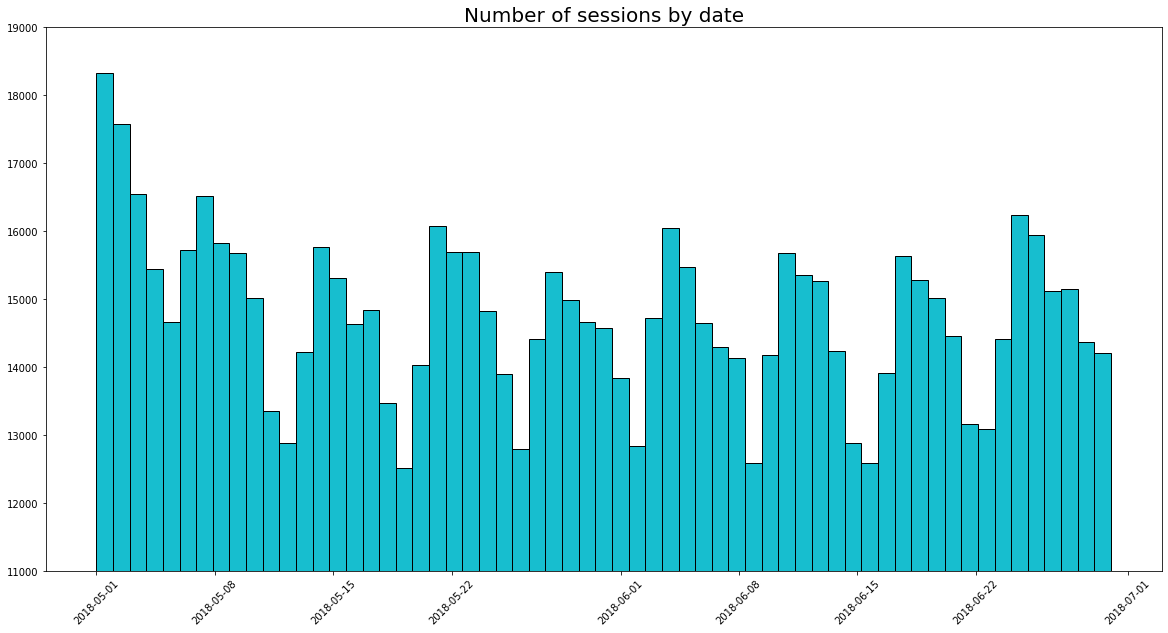

In [ ]:
x = pd.to_datetime(data.ymd,format = '%Y%m%d', errors='coerce')
plt.rcParams["figure.figsize"] = (20,10)
plt.hist(x, bins = len(data.ymd.unique()), color = 'tab:cyan', edgecolor='black')
plt.title('Number of sessions by date', fontsize = 20)
plt.xticks(rotation=45)
plt.ylim(11000, 19000) 

(75.0, 190.0)

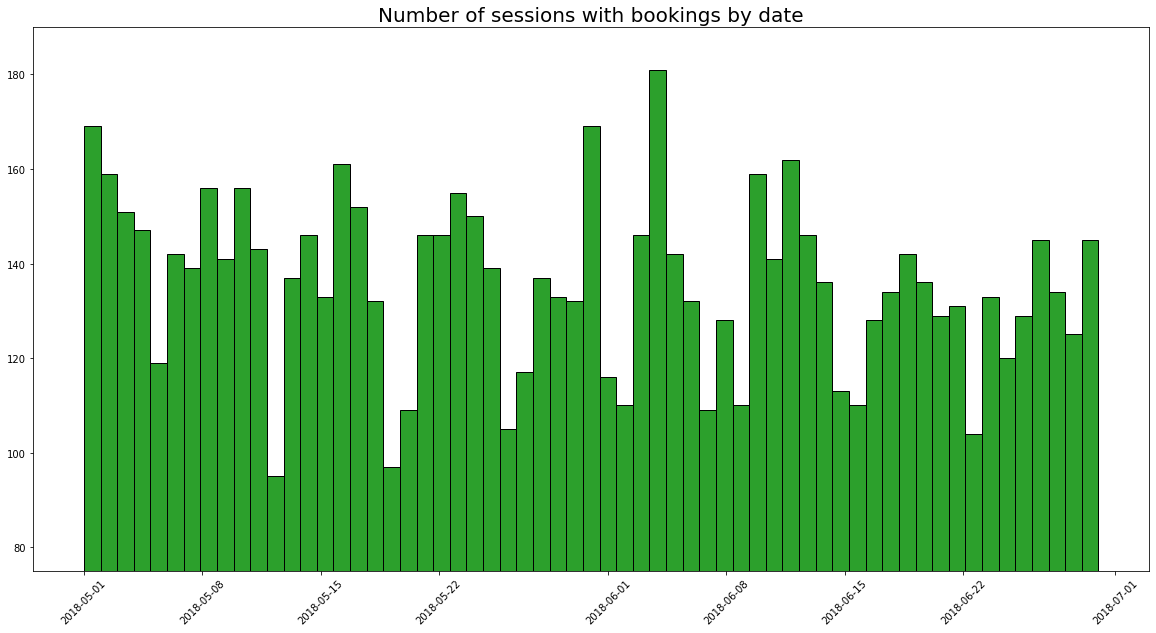

In [ ]:
x = pd.to_datetime(data.query('bookings > 0').ymd,format = '%Y%m%d', errors='coerce')
plt.hist(x, bins = len(data.ymd.unique()), color = 'tab:green', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Number of sessions with bookings by date', fontsize = 20)
plt.ylim(75, 190) 

Looking at the histograms above, we can see the periodic behaviour (probably weekly), so we will make a new column "day_of_week", and plot the data again.

In [ ]:
data['day_of_week'] = pd.to_datetime(data.ymd,format = '%Y%m%d', errors='coerce').dt.dayofweek # 0 - 6

(110000.0, 145000.0)

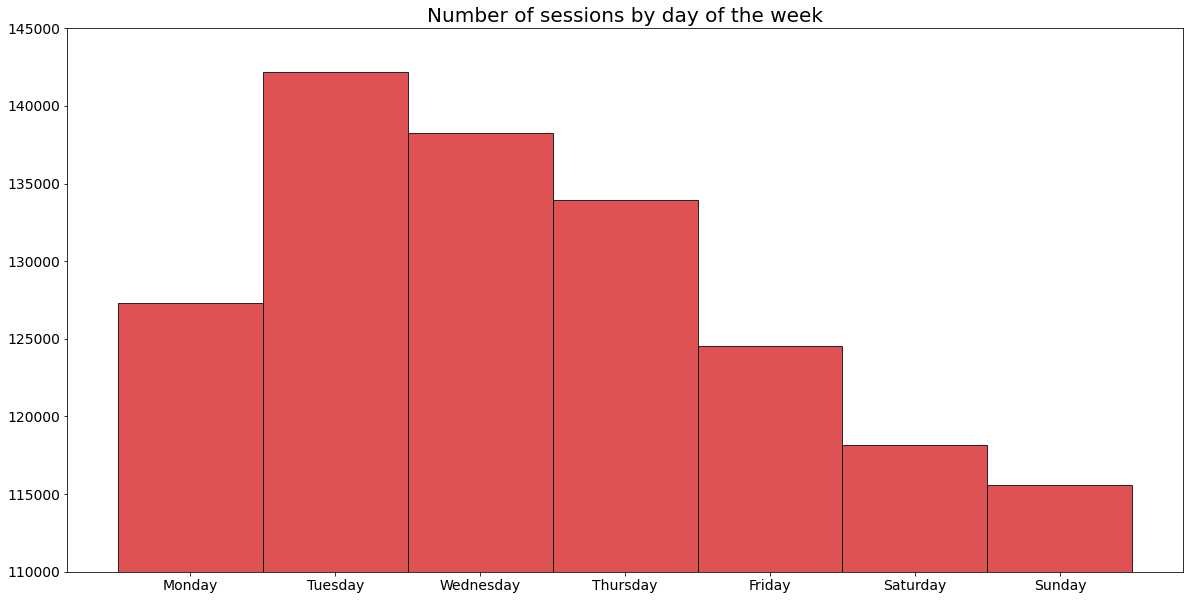

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.hist(data.day_of_week, bins = range(8), align = 'left', color = 'tab:red', edgecolor='black', alpha = 0.8)
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of sessions by day of the week', fontsize = 20)
plt.ylim(110000, 145000)

(800.0, 1400.0)

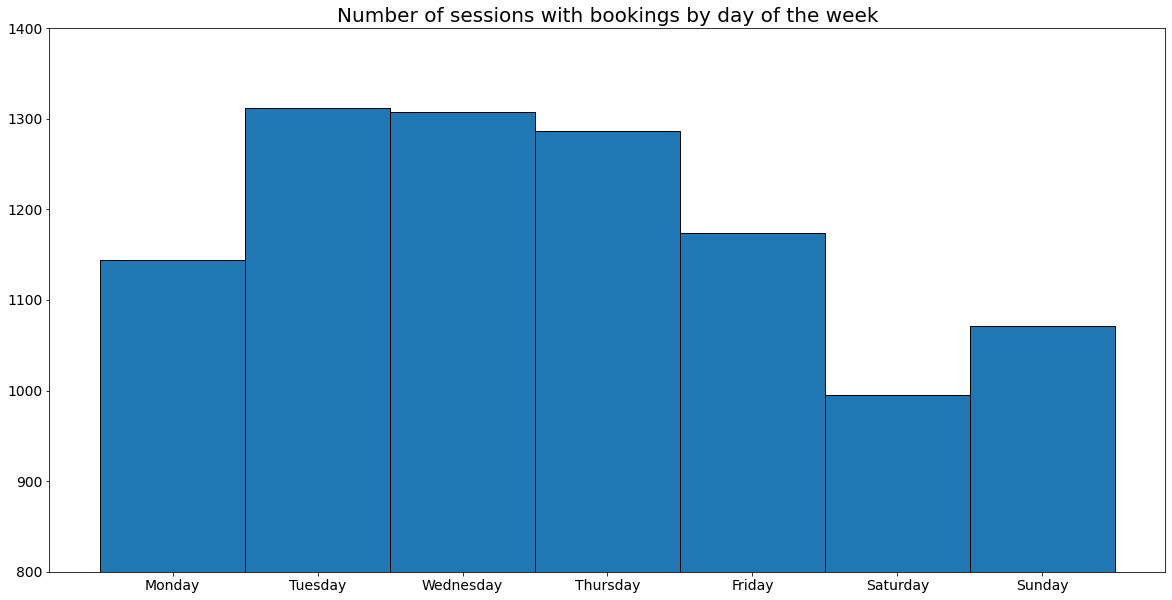

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.hist(data.query('bookings > 0').day_of_week, bins = range(8), align = 'left', edgecolor='black')
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of sessions with bookings by day of the week', fontsize = 20)
plt.ylim(800, 1400)

We can see that there are more sessions and bookings in the first half of the week. The discussion about this will be given below.

#### Number of sessions vs Arrival / Departure day

In [ ]:
data['arrival_day_of_week'] = pd.to_datetime(data.arrival_day,format = '%Y%m%d', errors='coerce').dt.dayofweek # 0 - 6
data['departure_day_of_week'] = pd.to_datetime(data.departure_day,format = '%Y%m%d', errors='coerce').dt.dayofweek # 0 - 6

Text(0.5, 1.0, 'Departure')

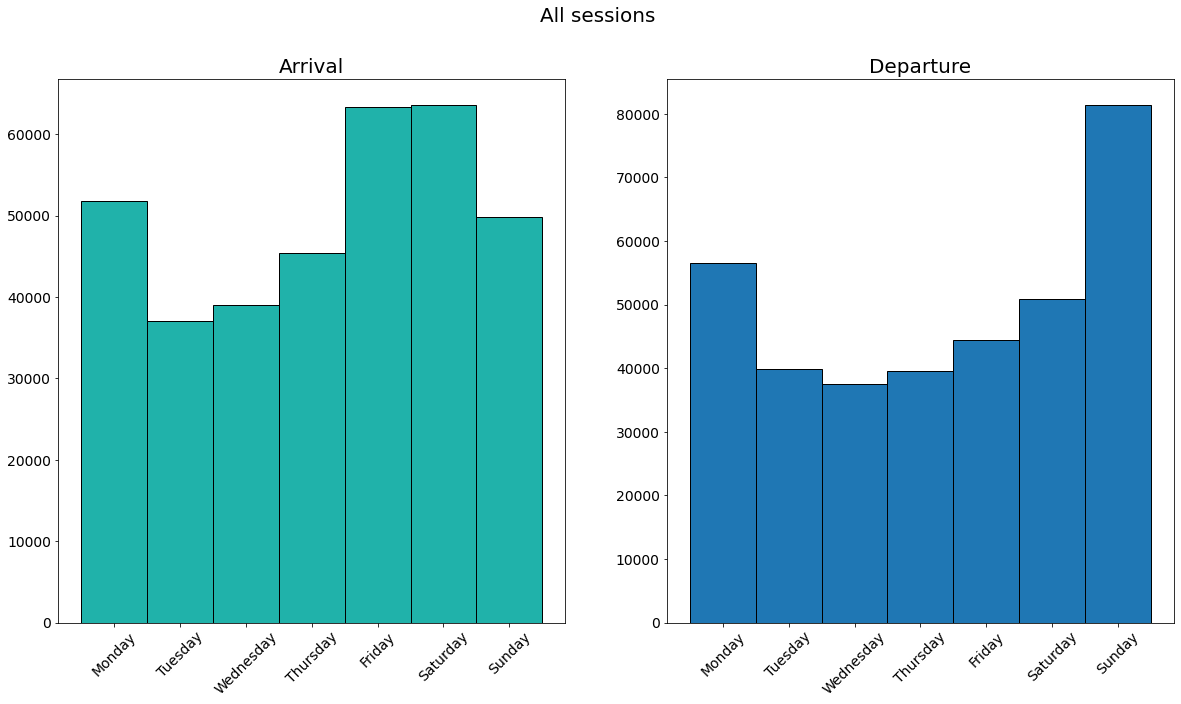

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('All sessions', fontsize=20)
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
ax1.hist(data.arrival_day_of_week, bins = range(8), align = 'left', color = 'lightseagreen', edgecolor = 'black')
ticks = [0, 1, 2, 3, 4, 5, 6]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, rotation = 45)
ax1.set_title('Arrival',fontsize=20)
ax2.hist(data.departure_day_of_week, bins = range(8), align = 'left', edgecolor = 'black')
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, rotation = 45)
ax2.set_title('Departure',fontsize=20)

Text(0.5, 1.0, 'Departure')

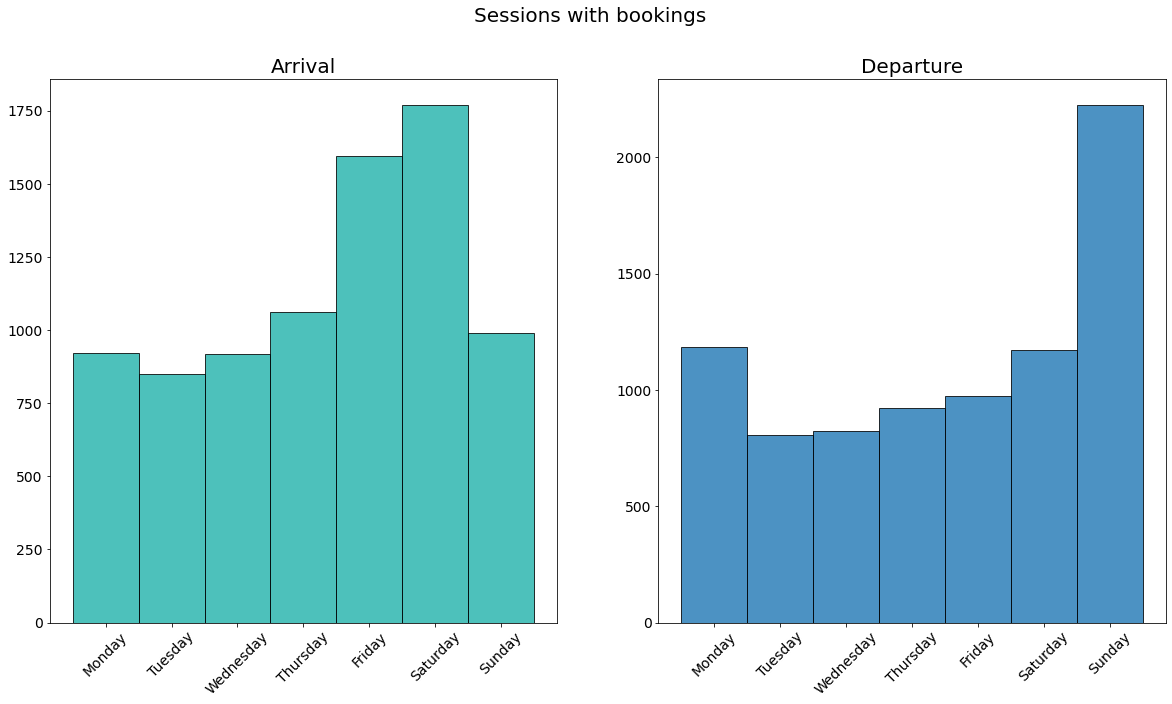

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sessions with bookings', fontsize=20)
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
ax1.hist(data.query('bookings > 0').arrival_day_of_week, bins = range(8), align = 'left', color = 'lightseagreen', edgecolor = 'black', alpha = 0.8)
ticks = [0, 1, 2, 3, 4, 5, 6]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, rotation = 45)
ax1.set_title('Arrival',fontsize=20)
ax2.hist(data.query('bookings > 0').departure_day_of_week, bins = range(8), align = 'left', edgecolor = 'black', alpha = 0.8)
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, rotation = 45)
ax2.set_title('Departure',fontsize=20)

Checking all the searches performed in the sessions, we see that more users are interested in travelling around weekends (which is expected, of course), and the same trend is seen with the searches that resulted in bookings.

#### Time span and duration of stay
(Time span is the number of days between the date of the session and the date of arrival.)

In [ ]:
data['time_span'] = pd.to_datetime(data.arrival_day,format = '%Y%m%d', errors='coerce').sub(pd.to_datetime(data.ymd,format = '%Y%m%d', errors='coerce'), axis=0)
data['duration_of_stay'] = pd.to_datetime(data.departure_day,format = '%Y%m%d', errors='coerce').sub(pd.to_datetime(data.arrival_day,format = '%Y%m%d', errors='coerce'), axis=0)
data['time_span'] = data['time_span'] / np.timedelta64(1, 'D')
data['duration_of_stay'] = data['duration_of_stay'] / np.timedelta64(1, 'D')

In [ ]:
data.describe()[['time_span', 'duration_of_stay']]

,time_span,duration_of_stay
count,350179.000000,350179.000000
mean,47.589707,2.759909
std,59.880698,3.327860
min,-400.000000,0.000000
25%,9.000000,1.000000
50%,25.000000,1.000000
75%,62.000000,3.000000
max,496.000000,91.000000


Note: Since we already had missing values in "arrival/departure_day" columns, we will have missing values in the newly formed ones as well.

Checking the statistics of these two columns, we see that there were some searches in sessions with the arrival day having past already (the minimal value in the "time_span" column is negative).

We will check theses entries:

In [ ]:
data.query('time_span < 0')

,ymd,session_id,tracking_id,platform,is_repeater,traffic_type,country_name,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,arrival_day,departure_day,transaction,day_of_week,arrival_day_of_week,departure_day_of_week,time_span,duration_of_stay
692,20180628,2018062802360003703,G58FZROA36,US,0,2,United States,18,2,0,1000,2100,0,20180627,20180628,0,3,2.0,3.0,-1.0,1.0
1833,20180605,2018060500933018830,F0GABR6YW8,AR,1,2,Argentina,20,1,0,129,2100,1,20180604,20180605,0,1,0.0,1.0,-1.0,1.0
3159,20180602,2018060202361016845,4ZHLHC3WR2,US,1,2,United States,20,1,1,1303,2100,5,20180601,20180602,1,5,4.0,5.0,-1.0,1.0
3771,20180504,2018050403902008029,L84IJ0JYRT,CO,0,2,Colombia,20,1,1,658,2100,15,20180503,20180504,1,4,3.0,4.0,-1.0,1.0
4641,20180630,2018063001906000911,L5MS2O1XO6,BR,1,2,Brazil,20,4,0,1512,2100,0,20180629,20180701,0,5,4.0,6.0,-1.0,2.0
4657,20180610,2018061001314018890,YKJPV152MT,US,0,2,United States,18,1,0,68,2100,3,20180609,20180610,0,6,5.0,6.0,-1.0,1.0
4746,20180506,2018050601376001181,S91496OJC8,US,0,2,United States,20,1,1,1116,2100,5,20180505,20180506,1,6,5.0,6.0,-1.0,1.0
6409,20180524,2018052400387014111,JJQKW67GLD,US,0,2,United States,20,2,0,291,2100,5,20180523,20180524,0,3,2.0,3.0,-1.0,1.0
7810,20180616,2018061600364003252,R67EQOFD44,US,1,2,United States,18,1,0,29,2100,0,20180615,20180616,0,5,4.0,5.0,-1.0,1.0
10165,20180616,2018061602989008394,X6VNR9VG7W,BR,0,2,Brazil,2,1,0,237,2100,28,20180615,20180616,0,5,4.0,5.0,-1.0,1.0


In [ ]:
data.query('time_span < 0').shape

(721, 21)

In [ ]:
data.query('time_span < 0')['time_span'].value_counts()

-1.0      691
-4.0        5
-7.0        4
-2.0        4
-3.0        3
-21.0       2
-5.0        2
-12.0       1
-400.0      1
-17.0       1
-16.0       1
-13.0       1
-22.0       1
-10.0       1
-6.0        1
-8.0        1
-39.0       1
Name: time_span, dtype: int64

There are 721 sessions in the dataset where the user searched for past dates. Out of these, 691 are only 1 day in the past, which might mean that some users were searching for accomodation for the same night, but after midnight (which could be very useful at times! :)). On another hand, selecting past dates on trivago website is not possible (at least at this moment; it might have been possible in the past), so those sessions choosing past dates could have been the developers testing the web app. More than 1 day in the past was eiher testing or an error in searching (or time travellers? :)).

In [ ]:
len(data.time_span.unique())

414

In [ ]:
len(data.duration_of_stay.unique())

84

Text(0.5, 0, 'Number of days')

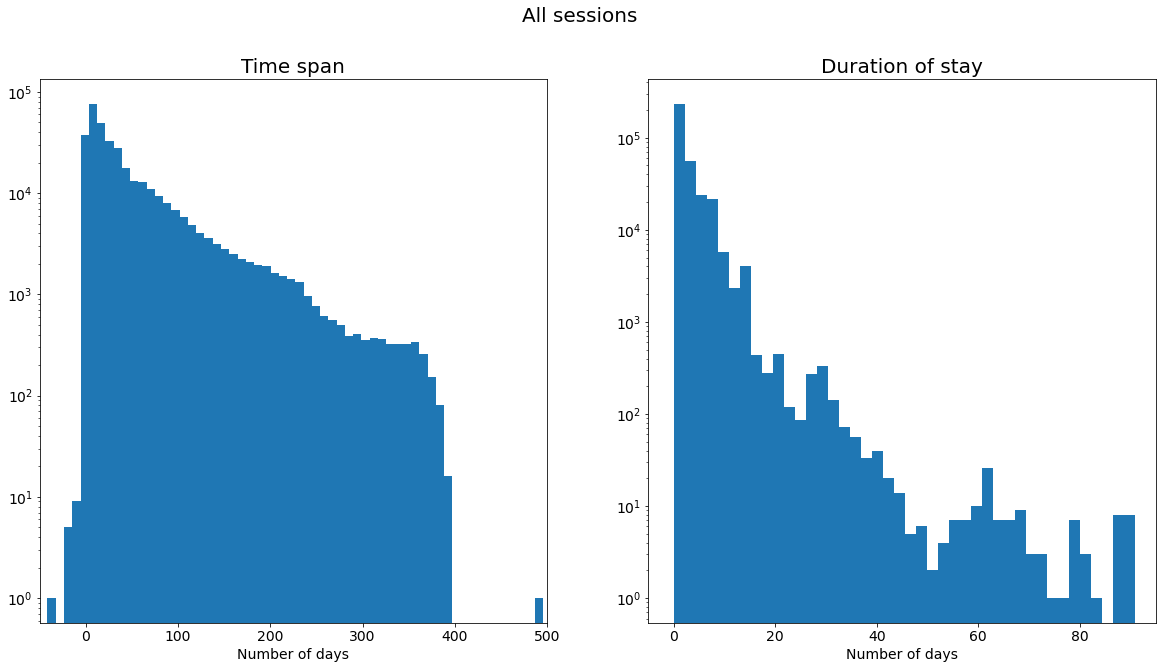

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('All sessions', fontsize=20)
ax1.hist(data.time_span, bins = 100)
ax2.hist(data.duration_of_stay, bins = 42)
ax1.set_xlim(-50,500)
ax1.set_yscale('log')
ax1.set_title('Time span',fontsize=20)
ax2.set_xlim(-5,95)
ax1.set_xlabel('Number of days',fontsize=14)
ax2.set_yscale('log')
ax2.set_title('Duration of stay',fontsize=20)
ax2.set_xlabel('Number of days',fontsize=14)

We can see on the right that many users are searching for a short trip, and on the left that many users are performing the search relatively close to the date of travel. The graphs bellow (only sessions with bookings) show similar trend. The first two graphs (more sessions and bookings in the beginning of the week) could be due to this - many users are planning to travel for the upcoming weekend.

Text(0.5, 0, 'Number of days')

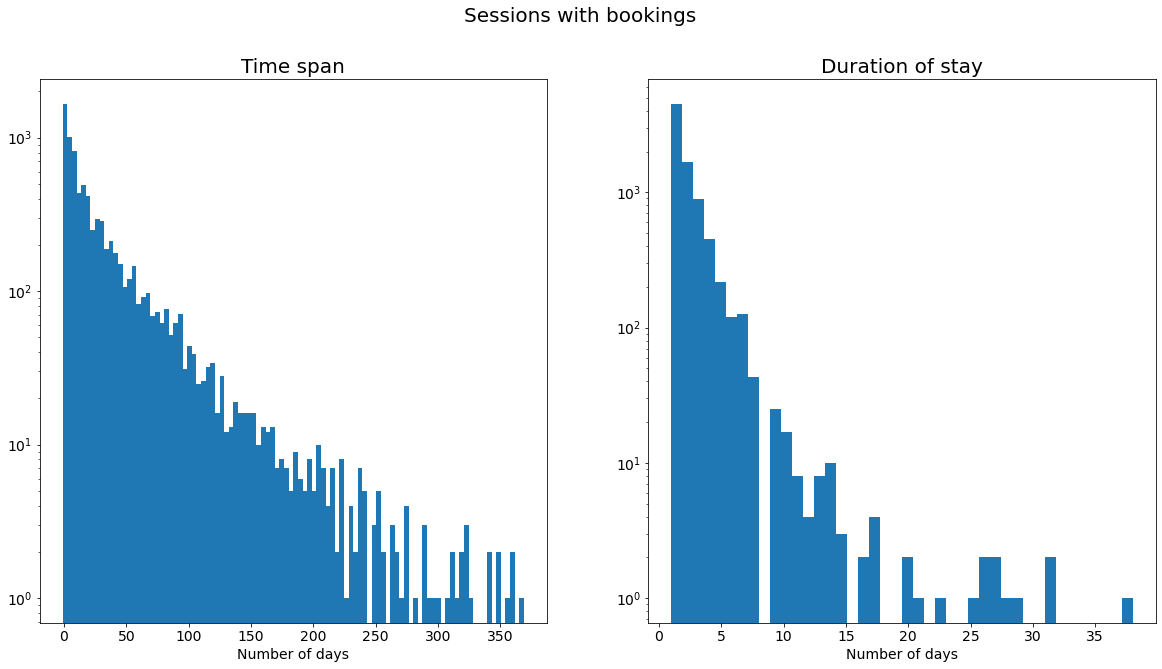

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sessions with bookings', fontsize=20)
ax1.hist(data.query('bookings > 0').time_span, bins = 100)
ax2.hist(data.query('bookings > 0').duration_of_stay, bins = 42)
ax1.set_yscale('log')
ax1.set_title('Time span',fontsize=20)
ax1.set_xlabel('Number of days',fontsize=14)
ax2.set_yscale('log')
ax2.set_title('Duration of stay',fontsize=20)
ax2.set_xlabel('Number of days',fontsize=14)

#### Booking statistics

In [ ]:
data.bookings.value_counts()

0    891711
1      7801
2       412
3        54
4        14
5         4
6         3
8         1
Name: bookings, dtype: int64

In [ ]:
data.bookings.value_counts()*100/data.shape[0]

0    99.079000
1     0.866778
2     0.045778
3     0.006000
4     0.001556
5     0.000444
6     0.000333
8     0.000111
Name: bookings, dtype: float64

In [ ]:
(data.bookings.value_counts()*100/(data.shape[0]-data.bookings.value_counts()[0]))[1:]

1    94.112679
2     4.970443
3     0.651466
4     0.168899
5     0.048257
6     0.036193
8     0.012064
Name: bookings, dtype: float64

As expected, most sessions end without bookings (99%). Out of the ones where booking occured, 94% made 1 booking (again, this was expected), ~5% made 2, and the rest are below 1%.


### Click per booking


I will try to find how many clickouts it was needed to have a booking.As I believe if the click per booking can be decreased then it can be count as a higher rate of conversion.

In [ ]:
data['clickouts_per_booking']= (data.clickouts) /( data.query('bookings >1').bookings)

In [ ]:
data['clickouts_per_booking']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
899995   NaN
899996   NaN
899997   NaN
899998   NaN
899999   NaN
Name: clickouts_per_booking, Length: 900000, dtype: float64

In [ ]:
data.describe()

,ymd,session_id,is_repeater,traffic_type,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,transaction,day_of_week,arrival_day_of_week,departure_day_of_week,time_span,duration_of_stay,clickouts_per_booking
count,9.000000e+05,9.000000e+05,900000.000000,900000.000000,900000.0000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,350179.000000,350179.00000,350179.000000,350179.000000,488.000000
mean,2.018056e+07,2.018056e+18,0.403043,4.967280,15.1980,0.843981,0.009877,392.361784,2117.316409,6.486588,0.009210,2.892189,3.203727,3.29694,47.589707,2.759909,2.401127
std,5.072988e+01,5.073065e+12,0.490510,2.372086,7.5183,1.813060,0.107203,989.495531,39.790707,30.995589,0.095526,1.966385,2.003692,2.17421,59.880698,3.327860,2.215634
min,2.018050e+07,2.018050e+18,0.000000,2.000000,2.0000,0.000000,0.000000,0.000000,2100.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-400.000000,0.000000,0.000000
25%,2.018052e+07,2.018052e+18,0.000000,2.000000,12.0000,0.000000,0.000000,12.000000,2106.000000,0.000000,0.000000,1.000000,1.000000,1.00000,9.000000,1.000000,1.000000
50%,2.018053e+07,2.018053e+18,0.000000,6.000000,18.0000,0.000000,0.000000,65.000000,2113.000000,0.000000,0.000000,3.000000,4.000000,4.00000,25.000000,1.000000,1.583333
75%,2.018062e+07,2.018062e+18,1.000000,6.000000,20.0000,1.000000,0.000000,287.000000,2116.000000,1.000000,0.000000,5.000000,5.000000,5.00000,62.000000,3.000000,3.000000
max,2.018063e+07,2.018063e+18,1.000000,10.000000,28.0000,86.000000,8.000000,83335.000000,2502.000000,3662.000000,1.000000,6.000000,6.000000,6.00000,496.000000,91.000000,14.000000


In [ ]:
data

,ymd,session_id,tracking_id,platform,is_repeater,traffic_type,country_name,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,arrival_day,departure_day,transaction,day_of_week,arrival_day_of_week,departure_day_of_week,time_span,duration_of_stay,clickouts_per_booking
0,20180626,2018062620046057322,FA6JXA8TAJ,UK,1,2,United Kingdom,16,0,0,29,2111,0,\N,\N,0,1,NaN,NaN,NaN,NaN,NaN
1,20180518,2018051821943006017,0X7RLU6KF7,BR,0,2,Brazil,2,3,0,1485,2100,27,20180530,20180531,0,4,2.0,3.0,12.0,1.0,NaN
2,20180508,2018050821020053928,0I59VWLQW0,UK,0,2,United Kingdom,20,0,0,143,2100,0,\N,\N,0,1,NaN,NaN,NaN,NaN,NaN
3,20180507,2018050706015039122,JXNHOBQL50,CH,0,2,Switzerland,28,0,0,69,2100,0,\N,\N,0,0,NaN,NaN,NaN,NaN,NaN
4,20180523,2018052320052048087,W24I0V5Z2L,IT,0,2,Italy,20,6,0,887,2100,100,20180609,20180610,0,2,5.0,6.0,17.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,20180630,2018063003683001079,X3H6E73Q2Z,ID,0,8,Indonesia,20,0,0,32,2113,0,\N,\N,0,5,NaN,NaN,NaN,NaN,NaN
899996,20180509,2018050921028019687,ODJ3C70BA9,DE,0,8,Germany,18,0,0,7,2116,0,\N,\N,0,2,NaN,NaN,NaN,NaN,NaN
899997,20180519,2018051904328017578,N0RPBRBKN3,US,1,8,United States,2,1,0,42,2116,0,20180606,20180609,0,5,2.0,5.0,18.0,3.0,NaN
899998,20180506,2018050601379019834,BF47FQ35KR,AU,0,8,Australia,18,0,0,3,2116,0,\N,\N,0,6,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['ymd'] =pd.to_datetime(data.ymd,format = '%Y%m%d', errors='coerce')

In [ ]:
data


,ymd,session_id,tracking_id,platform,is_repeater,traffic_type,country_name,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,arrival_day,departure_day,transaction,day_of_week,arrival_day_of_week,departure_day_of_week,time_span,duration_of_stay,clickouts_per_booking
0,2018-06-26,2018062620046057322,FA6JXA8TAJ,UK,1,2,United Kingdom,16,0,0,29,2111,0,\N,\N,0,1,NaN,NaN,NaN,NaN,NaN
1,2018-05-18,2018051821943006017,0X7RLU6KF7,BR,0,2,Brazil,2,3,0,1485,2100,27,20180530,20180531,0,4,2.0,3.0,12.0,1.0,NaN
2,2018-05-08,2018050821020053928,0I59VWLQW0,UK,0,2,United Kingdom,20,0,0,143,2100,0,\N,\N,0,1,NaN,NaN,NaN,NaN,NaN
3,2018-05-07,2018050706015039122,JXNHOBQL50,CH,0,2,Switzerland,28,0,0,69,2100,0,\N,\N,0,0,NaN,NaN,NaN,NaN,NaN
4,2018-05-23,2018052320052048087,W24I0V5Z2L,IT,0,2,Italy,20,6,0,887,2100,100,20180609,20180610,0,2,5.0,6.0,17.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,2018-06-30,2018063003683001079,X3H6E73Q2Z,ID,0,8,Indonesia,20,0,0,32,2113,0,\N,\N,0,5,NaN,NaN,NaN,NaN,NaN
899996,2018-05-09,2018050921028019687,ODJ3C70BA9,DE,0,8,Germany,18,0,0,7,2116,0,\N,\N,0,2,NaN,NaN,NaN,NaN,NaN
899997,2018-05-19,2018051904328017578,N0RPBRBKN3,US,1,8,United States,2,1,0,42,2116,0,20180606,20180609,0,5,2.0,5.0,18.0,3.0,NaN
899998,2018-05-06,2018050601379019834,BF47FQ35KR,AU,0,8,Australia,18,0,0,3,2116,0,\N,\N,0,6,NaN,NaN,NaN,NaN,NaN


In [ ]:
x = np.sort(data.ymd.unique())
y= data.query('bookings>1').groupby('ymd').mean().clickouts_per_booking.values

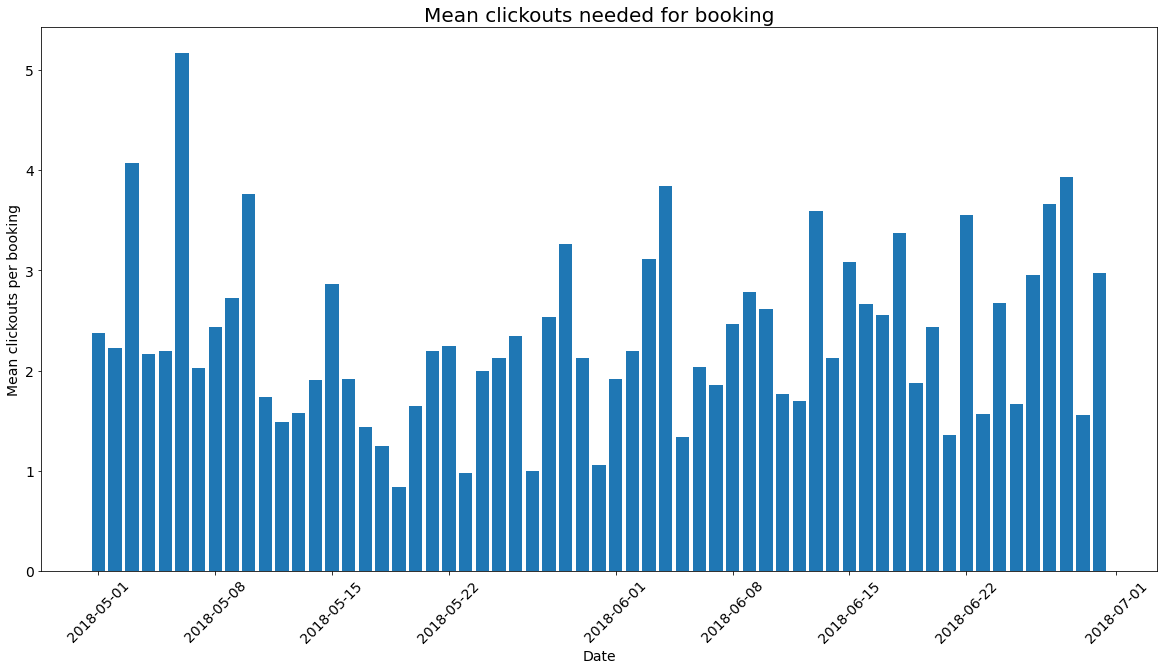

In [ ]:
plt.bar(x,y)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Mean clickouts per booking',fontsize=14)
plt.title('Mean clickouts needed for booking', fontsize=20)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
data.query('bookings>0').groupby('ymd').mean().clickouts_per_booking.describe()

count    61.000000
mean      2.342923
std       0.867416
min       0.833333
25%       1.733333
50%       2.194444
75%       2.785714
max       5.166667
Name: clickouts_per_booking, dtype: float64

From this description we can see the mean clickouts need for bookings is 2.34 and maximum is 5.16 if we count only when bookings are made. There can be seen
some periodic pattern if we look at the graph. We can investigate how this plot looks like on the days of the week.

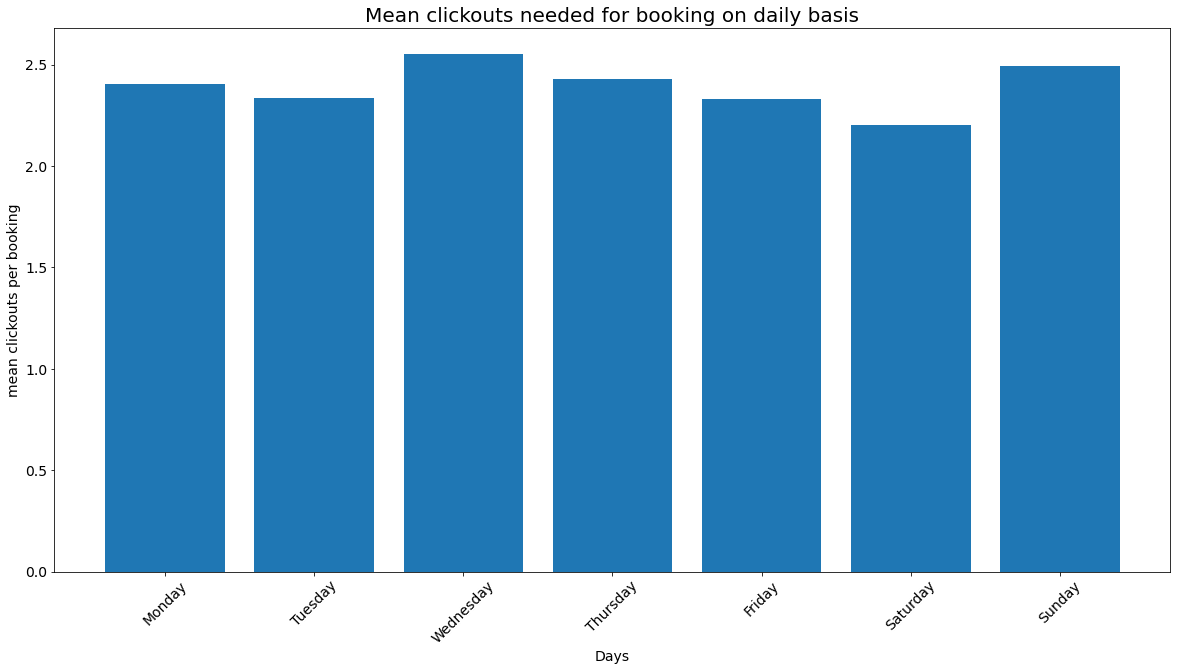

In [ ]:
x = np.sort(data.day_of_week.unique())
y= data.query('bookings>1').groupby('day_of_week').mean().clickouts_per_booking.values
plt.bar(x,y)
plt.xlabel('Days',fontsize=14)
plt.ylabel('mean clickouts per booking',fontsize=14)
plt.title('Mean clickouts needed for booking on daily basis', fontsize=20)
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],rotation = 45)
plt.show()

In [ ]:
data.query('bookings>1').groupby('day_of_week').clickouts_per_booking.describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
0,84.0,2.406746,2.304701,0.000000,1.0,1.500000,3.000000,11.5
1,81.0,2.337449,2.309999,0.000000,1.0,1.500000,2.500000,12.5
2,70.0,2.553333,2.509731,0.000000,1.0,2.000000,2.916667,11.5
3,59.0,2.428531,2.339385,0.000000,1.0,1.500000,3.100000,10.5
4,56.0,2.330357,1.622596,0.333333,1.0,2.000000,3.375000,7.0
5,57.0,2.204386,1.870523,0.000000,1.0,2.000000,3.000000,9.0
6,81.0,2.494856,2.304824,0.333333,1.0,1.666667,3.000000,14.0


There is not that much difference in mean clickouts per booking between the days of the week which we can see from the graph and datas in the table. It oscillates between 2.2 to 2.5

# Task 2  - Actions investigation (session_actions.csv)

### Descriptive Analysis

#### Datadrame shape -number of rows and column

In [ ]:
actions.shape

(1169169, 6)

In [ ]:
actions.head(10)

,session_id,tracking_id,date_id,action_id,action_reference,step
0,2018051219047047198,W3ZTG14L5L,2018051219051031064,2113,38715,27
1,2018053117093000001,001J2RM6SK,2018053117093000001,2100,0,1
2,2018051219047047198,W3ZTG14L5L,2018051219051031871,2160,62,28
3,2018053117093000001,001J2RM6SK,2018053117093002301,2100,0,3
4,2018051219047047198,W3ZTG14L5L,2018051219051051853,2113,38715,29
5,2018053117093000001,001J2RM6SK,2018053117093007130,2111,31477,8
6,2018051219047047198,W3ZTG14L5L,2018051219051052502,2160,63,30
7,2018053117093000001,001J2RM6SK,2018053117093023937,2111,31477,12
8,2018051219047047198,W3ZTG14L5L,2018051219051078292,2113,38715,31
9,2018053117093000001,001J2RM6SK,2018053117093024738,2160,62,13


In [ ]:
actions.dtypes

session_id           int64
tracking_id         object
date_id              int64
action_id            int64
action_reference    object
step                 int64
dtype: object

# Merging the CSV Files

I am merging the data and action tables together on the basis of the tracking_id just to have a better grasp on the data and perhaps it will lead to a better analysis.

In [ ]:
merged = data.merge(actions, on = 'tracking_id')

In [ ]:
common_ten = merged.action_id.value_counts()[0:9]

In [ ]:
common_ten

2142    5685
2160    2516
2113    2507
2100    1093
8001    1058
2116    1040
2455     883
2350     801
2358     775
Name: action_id, dtype: int64

From the merged dataframe the most common action_id is 2142 which has hapeened 5685 times

In [ ]:
merged.query('action_id == 2142')

,ymd,session_id_x,tracking_id,platform,is_repeater,traffic_type,country_name,agent_id,clickouts,bookings,session_duration,entry_page,total_ctp,arrival_day,departure_day,transaction,day_of_week,arrival_day_of_week,departure_day_of_week,time_span,duration_of_stay,clickouts_per_booking,session_id_y,date_id,action_id,action_reference,step
49,2018-05-03,2018050304087001144,HYTVWVXKU2,IL,1,2,Israel,2,8,0,721,2100,1,20180731,20180805,0,3,1.0,6.0,89.0,5.0,NaN,2018050111044016437,2018050111087020323,2142,1778243,72
182,2018-06-12,2018061219000002824,5KI57LI1GD,UK,1,2,United Kingdom,18,0,0,28,2100,0,\N,\N,0,1,NaN,NaN,NaN,NaN,NaN,2018060700003027252,2018060700005000432,2142,12595,28
183,2018-06-12,2018061219000002824,5KI57LI1GD,UK,1,2,United Kingdom,18,0,0,28,2100,0,\N,\N,0,1,NaN,NaN,NaN,NaN,NaN,2018060700003027252,2018060700005010315,2142,12595,29
266,2018-06-08,2018060804625009539,19EE64HA4D,JP,0,2,Japan,2,0,0,7126,2316,0,\N,\N,0,4,NaN,NaN,NaN,NaN,NaN,2018060700639004774,2018060701620004619,2142,1015565,33
267,2018-06-08,2018060804625009539,19EE64HA4D,JP,0,2,Japan,2,0,0,7126,2316,0,\N,\N,0,4,NaN,NaN,NaN,NaN,NaN,2018060700639004774,2018060701620004620,2142,1015565,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23431,2018-06-22,2018062208015040632,N1PRJLVRIV,TR,1,8,Turkey,2,0,0,8,2116,0,\N,\N,0,4,NaN,NaN,NaN,NaN,NaN,2018062411087073831,2018062412023053122,2142,2439770,48
23432,2018-06-22,2018062208015040632,N1PRJLVRIV,TR,1,8,Turkey,2,0,0,8,2116,0,\N,\N,0,4,NaN,NaN,NaN,NaN,NaN,2018062411087073831,2018062412023053121,2142,2439770,49
23433,2018-06-22,2018062208015040632,N1PRJLVRIV,TR,1,8,Turkey,2,0,0,8,2116,0,\N,\N,0,4,NaN,NaN,NaN,NaN,NaN,2018062411087073831,2018062412023053123,2142,2439770,50
23434,2018-06-22,2018062208015040632,N1PRJLVRIV,TR,1,8,Turkey,2,0,0,8,2116,0,\N,\N,0,4,NaN,NaN,NaN,NaN,NaN,2018062411087073831,2018062412023060173,2142,2439770,51


# Trivago session start , most common actions and relation with the product

Trivago session start when the user is on the landing page. now to see the what is the most common action we can just count how many time an antion has happened. Lets see what are the most common action.

In [ ]:
actions.action_id.value_counts()

2142    296136
2160    127704
2113    124778
2100     59791
8001     47348
2116     43571
2455     42372
2350     38473
2358     38023
2351     33863
2115     31185
2111     29713
2306     26947
2371     25871
2119     19833
2114     18725
2155     18055
2375     15797
2257     11358
2121     10802
2296     10455
2369      8787
2145      8328
2175      7840
2345      7639
2501      6936
2313      5816
2123      5453
2146      5427
2143      4816
2156      3663
2124      3339
2216      3035
2122      2980
2286      2245
2399      2161
2227      1845
2188      1553
2502      1350
2262      1118
2356      1085
2200       961
2440       947
2465       880
2128       829
2472       804
8101       746
2125       660
2302       637
2255       519
2364       515
2451       348
2307       342
2284       324
2130       313
2324       280
2136       240
2470       239
2126       219
2452       219
2133       213
2353       199
8002       189
2446       185
8020       164
2108       163
2205      

In [ ]:
common_ten = actions.action_id.value_counts()[0:9]

In [ ]:
common_ten

2142    296136
2160    127704
2113    124778
2100     59791
8001     47348
2116     43571
2455     42372
2350     38473
2358     38023
Name: action_id, dtype: int64

The most common action_id is 2142 which has happened 296136 times. Let investigate which action it refers to i mean to look at the action_reference coloumns.

### Most common action reference which refers to the most common action id

In [ ]:
actions.query('action_id == 2142').action_reference.value_counts()

2767250    281
3974728    234
3813752    198
100224     177
97298      169
          ... 
20857        1
8934         1
598626       1
3507802      1
42277        1
Name: action_reference, Length: 21545, dtype: int64

Here i took only the most common action_reference for action_id = 2142 which is the most common action_id in the data set. The action_reference 2767250 has happened 281 times.

### Most common final action

As the step column means the rank of action with time ascending. I assume this refers to the final action taken by the user. Counting how many times a step appear in the data we can say what is the most common final action.


In [ ]:
actions.step.value_counts()

1      35957
17     22722
18     22703
19     22658
3      22243
20     22227
16     22107
21     21626
15     21387
12     21172
22     21012
11     21011
13     20878
14     20813
23     20281
24     19544
10     19373
25     18850
26     18131
27     17346
28     16831
29     16229
9      15996
30     15617
31     15067
32     14498
33     14043
34     13585
35     13127
36     12659
37     12301
8      12259
38     11891
39     11655
40     11251
41     10894
42     10644
43     10310
44     10023
45      9682
46      9478
47      9197
7       8987
48      8963
49      8711
50      8518
51      8261
52      8059
53      7837
4       7628
54      7616
55      7447
56      7232
57      7122
58      6880
59      6698
60      6519
61      6333
2       6272
62      6175
63      6001
64      5874
65      5760
66      5611
67      5466
68      5294
69      5153
5       5034
6       4994
70      4989
71      4904
72      4753
73      4629
74      4579
75      4445
76      4339
77      4259

In [ ]:
df = actions.query('step ==1')[['action_id','action_reference']]

In [ ]:
df.action_id.value_counts()

2100    28135
2113     2454
2116     2428
2111      910
2115      398
2142      313
2114      293
2227      211
2160      153
2365      103
2374       76
2455       50
2306       46
2358       44
2257       39
2375       37
2345       30
2119       30
2371       22
2143       19
2155       17
2145       15
2296       14
2313       12
2120       11
2351       11
2156        9
2188        9
2395        7
2350        6
2122        6
2464        6
2369        5
2123        5
2121        5
2146        5
2284        4
2440        4
2319        3
2501        3
2286        1
2364        1
2399        1
2470        1
2279        1
2472        1
2130        1
2255        1
2302        1
Name: action_id, dtype: int64

Text(0.5, 0, 'Action Id')

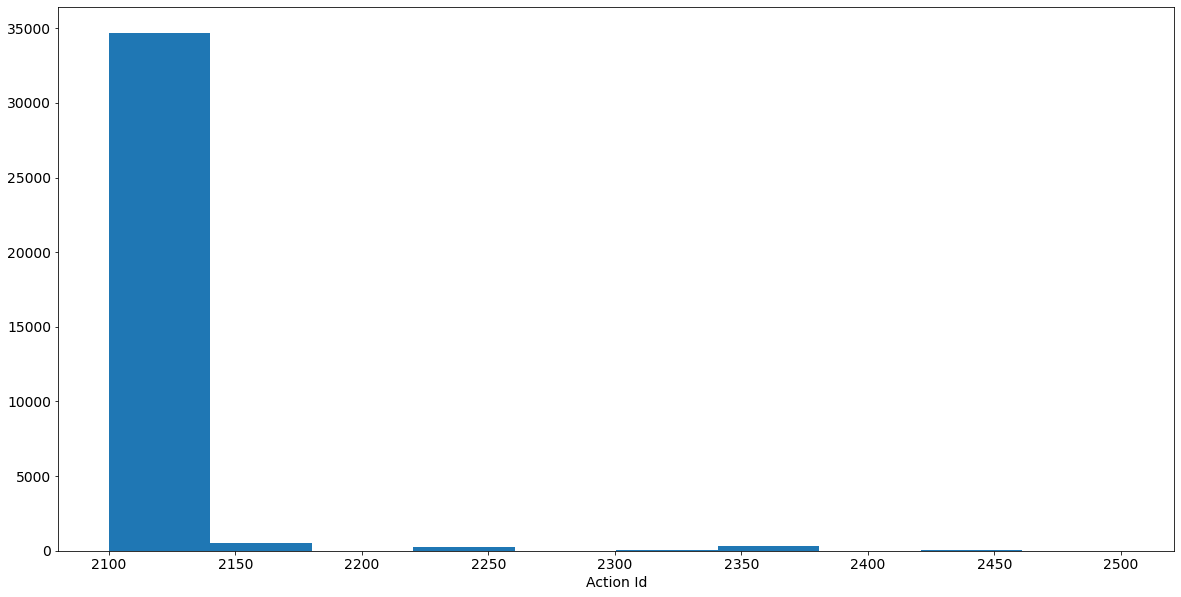

In [ ]:
plt.hist(df['action_id'])
plt.xlabel('Action Id', fontsize = 14)

Here we can see most of values of column step =1 comes from the action_id = 2100 which happens 28135 times. Let us see what action it refers to.

In [ ]:
df.query('action_id == 2100').action_reference.value_counts()

0    28135
Name: action_reference, dtype: int64

From here we can see all of the actions by action_id 2100 refers to action_reference 0 which happens 28135 times. I think this is the most common final action with action_reference id 0. I guess here the user made a booking or they just left the site. In most of the cases they leave the sites which we will analyze later in merged table.

### Action Distribution

In [ ]:
actions.action_reference.value_counts()

0          136692
1           64807
2           35739
62          30592
6           27664
            ...  
11840           1
1016049         1
1846            1
88731           1
5445706         1
Name: action_reference, Length: 66513, dtype: int64

In [ ]:
actions['action_reference'].describe()

count     1169169
unique      66513
top             0
freq       136692
Name: action_reference, dtype: object

In [ ]:
actions.step.value_counts()

1      35957
17     22722
18     22703
19     22658
3      22243
20     22227
16     22107
21     21626
15     21387
12     21172
22     21012
11     21011
13     20878
14     20813
23     20281
24     19544
10     19373
25     18850
26     18131
27     17346
28     16831
29     16229
9      15996
30     15617
31     15067
32     14498
33     14043
34     13585
35     13127
36     12659
37     12301
8      12259
38     11891
39     11655
40     11251
41     10894
42     10644
43     10310
44     10023
45      9682
46      9478
47      9197
7       8987
48      8963
49      8711
50      8518
51      8261
52      8059
53      7837
4       7628
54      7616
55      7447
56      7232
57      7122
58      6880
59      6698
60      6519
61      6333
2       6272
62      6175
63      6001
64      5874
65      5760
66      5611
67      5466
68      5294
69      5153
5       5034
6       4994
70      4989
71      4904
72      4753
73      4629
74      4579
75      4445
76      4339
77      4259

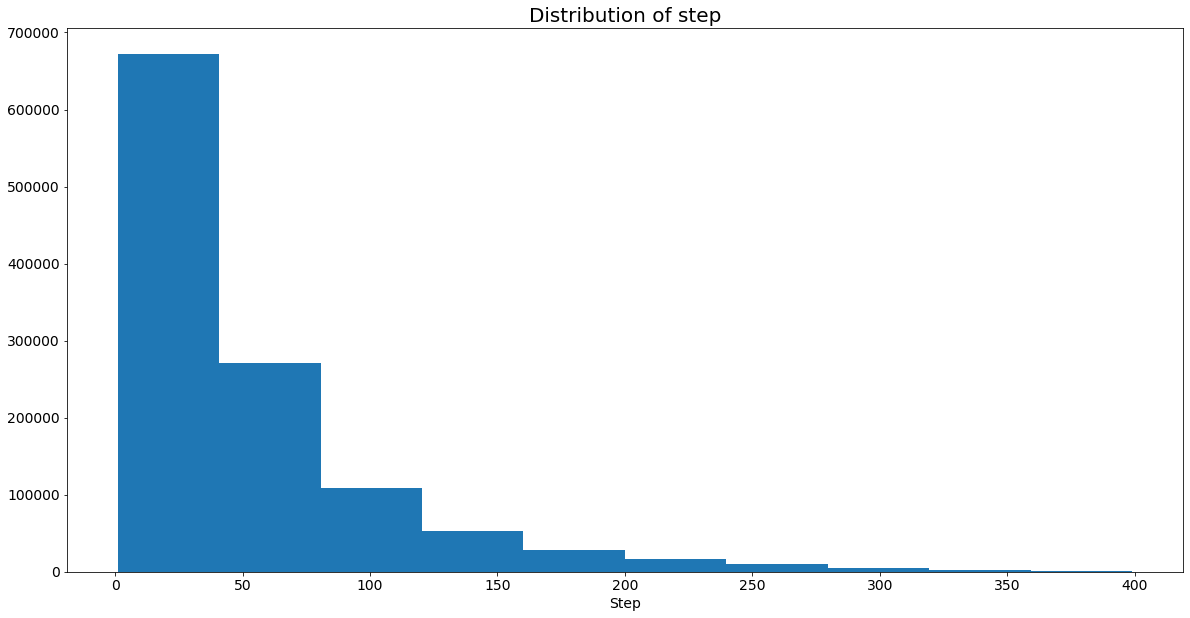

In [ ]:
plt.hist(actions['step'])
plt.xlabel('Step', fontsize = 14)
plt.title('Distribution of step', fontsize =20)
plt.show()

Most of the action refer to step 1 and in the range 0 to 50. which can be seen from the plot above and 

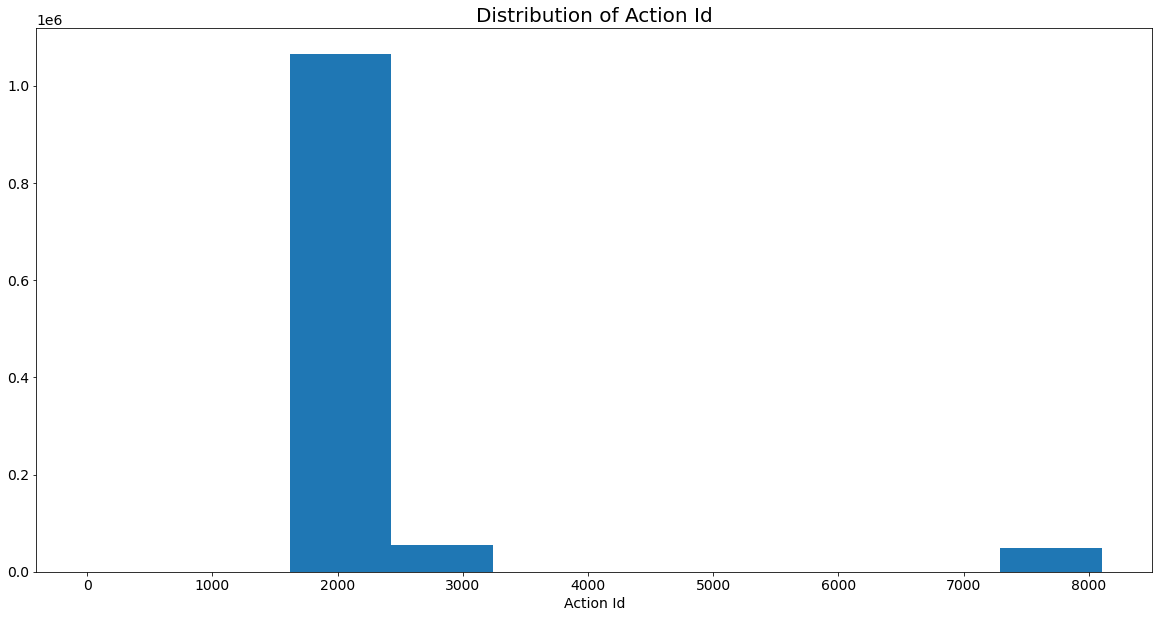

In [ ]:
plt.hist(actions['action_id'])
plt.xlabel('Action Id', fontsize = 14)
plt.title('Distribution of Action Id', fontsize =20)
plt.show()

In [ ]:
actions.action_id.value_counts()[0:10]

2142    296136
2160    127704
2113    124778
2100     59791
8001     47348
2116     43571
2455     42372
2350     38473
2358     38023
2351     33863
Name: action_id, dtype: int64

From the plot above and the result it can be seen that most of actions are done with action id nearby 2100. The most action happened from id 2142 which is 296136 times. There are some actions with action id 8001 as well.

In [ ]:
actions.action_reference.value_counts()[0:10]

0       136692
1        64807
2        35739
62       30592
6        27664
80       26816
63       26639
7        23424
1110     17918
10       17346
Name: action_reference, dtype: int64

Let us see what happens with the combined data from 2 csv fileswhich i named above merged. Lets see what happens with step value 1 and action_id 2142 and action_reference 0.

#### Bookings and clickouts for step = 1

In [ ]:
step_1 = merged.query('step==1')[['clickouts', 'bookings', 'action_reference','action_id','step']]

In [ ]:
step_1.groupby('step').sum()

,clickouts,bookings,action_id
step,,,
1,928,15,1472485


for step value 1 only 15 bookings happened and there were abount 928 clickouts. So there were almost 62 clickouts for 1 bookings. If we count booking as a coversion the result is not satisfactory for step 1 as if the value is lower means higher rate of conversion.

#### Bookings and clickouts for action_id = 2142

In [ ]:
id_2142 = merged.query('action_id==2142')[['clickouts', 'bookings', 'action_reference','action_id','step']]

In [ ]:
id_2142

,clickouts,bookings,action_reference,action_id,step
49,8,0,1778243,2142,72
182,0,0,12595,2142,28
183,0,0,12595,2142,29
266,0,0,1015565,2142,33
267,0,0,1015565,2142,34
...,...,...,...,...,...
23431,0,0,2439770,2142,48
23432,0,0,2439770,2142,49
23433,0,0,2439770,2142,50
23434,0,0,2439770,2142,51


In [ ]:
id_2142.groupby('action_id').sum()

,clickouts,bookings,step
action_id,,,
2142,12437,96,527799


Here with the action_id 2142 there are 96 bookings and 12437 clickouts. So there were almost 130 clickouts for 1 bookings on an average. If we count booking as a coversion the result is not satisfactory for action_id 2142 as if the value is lower means higher rate of conversion. But here the values are very high.

In [ ]:
ref_0 =  merged.query('action_reference== "0"')[['clickouts', 'bookings', 'action_reference','action_id','step']]

In [ ]:
ref_0

,clickouts,bookings,action_reference,action_id,step
0,8,0,0,2100,1
1,8,0,0,2100,6
2,8,0,0,2306,11
14,8,0,0,2175,23
23,8,0,0,2175,34
...,...,...,...,...,...
23502,3,0,0,2350,97
23521,3,0,0,2306,138
23522,3,0,0,2350,139
23534,1,0,0,2100,1


In [ ]:
ref_0.groupby('action_reference').sum()

,clickouts,bookings,action_id,step
action_reference,,,,
0,4410,53,5658524,75958


Here with the action_reference 0 there are 53 bookings and 4410 clickouts. So there were almost 83 clickouts for 1 bookings on an average. If we count booking as a coversion the result is not satisfactory for action_reference 0 as if the value is lower means higher rate of conversion. But here the values are very high.

### Conversions and ways to verify and Highest impact on conversion

If we looked at the merged table from the two csv files and look at the transaction column value = 1 we can find out the conversion and action_id related to it. The transaction column value 1 means there was at least one booking made and whenever a booking made means a conversion has happened

In [ ]:
conversion = merged.query('transaction ==1 ')[['action_id','step','action_reference','bookings','transaction']]

In [ ]:
conversion

,action_id,step,action_reference,bookings,transaction
890,2111,2,94574,1,1
891,2227,3,1,1,1
1700,2100,1,0,1,1
1701,2100,3,0,1,1
1702,2306,10,0,1,1
1703,2358,11,1,1,1
1704,2116,15,58152,1,1
1705,2350,16,2,1,1
1706,2116,18,58152,1,1
1707,2160,19,62,1,1


#### Action_id and conversions 

In [ ]:
conv = conversion.groupby('action_id').sum()

In [ ]:
conv

,step,bookings,transaction
action_id,,,
2100,208,24,24
2111,296,13,13
2113,652,23,23
2114,1022,24,24
2115,377,20,17
2116,294,18,18
2119,796,15,15
2121,180,4,4
2123,159,3,3


Here we can see the distribution of bookings according to action_id. Lets us look at only the bookings in a more sorted manner

In [ ]:
conversion.groupby('action_id').sum().bookings.sort_values(ascending = False)

action_id
2142    96
2371    82
2160    52
8001    41
2100    24
2114    24
2113    23
2455    20
2115    20
2350    19
2116    18
2119    15
2345    14
2306    14
2111    13
8101    12
2358    11
2375     9
2156     7
2227     4
2121     4
2123     3
2313     3
2155     2
2296     2
2146     2
2145     2
2175     2
2351     2
2369     2
2143     1
2128     1
2279     1
Name: bookings, dtype: int64

##### From above we can see most of the booking happened to action_id 2142 and value is 96, then id 2371 82 times. This are the action ids with highest conversion as I can say

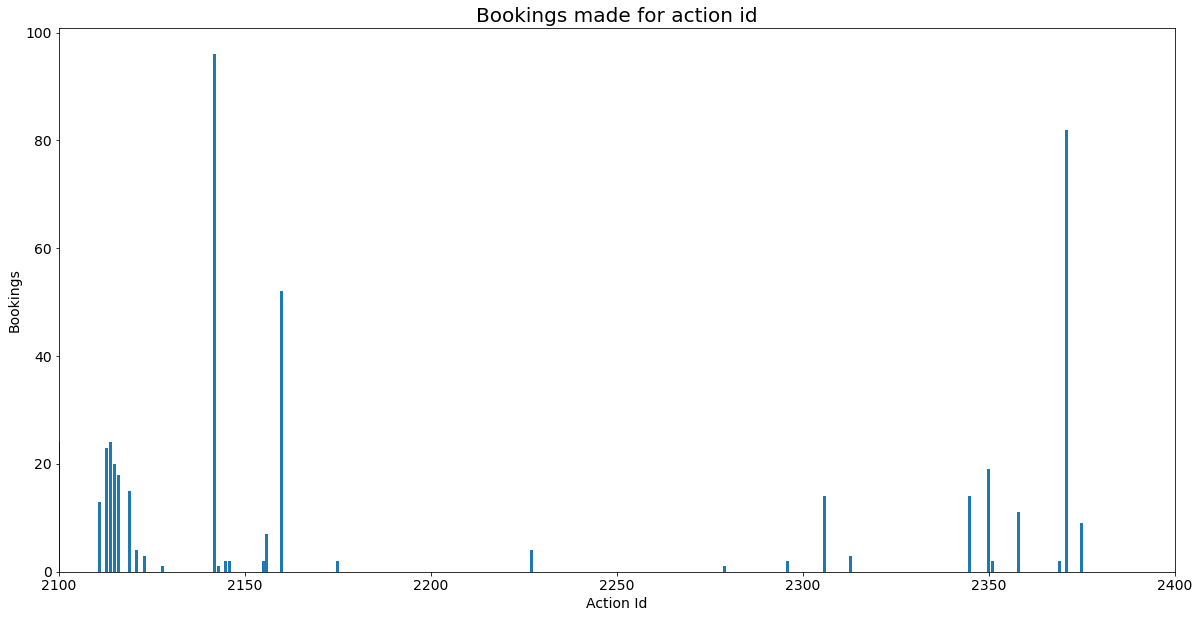

In [ ]:

keys = [action_id for action_id, df in conversion.groupby(['action_id'])]

plt.bar(keys,conversion.groupby(['action_id']).sum()['bookings'])
plt.xlim(2100,2400)
plt.xlabel('Action Id', fontsize = 14)
plt.ylabel('Bookings', fontsize = 14)
plt.title('Bookings made for action id', fontsize = 20)
plt.show()

From the graph it is visible that there is a peak near action_id 2150 which is to be specific 2142 another at 2371 

In [ ]:
 ref =conversion.groupby('action_reference').sum()

In [ ]:
ref

,action_id,step,bookings,transaction
action_reference,,,,
0,117002,1016,53,53
1,73832,908,34,32
10090778,16002,105,2,2
1110,180196,5105,76,76
11475,4242,99,2,2
1192644,95315,376,20,20
11930,12285,330,3,3
12,4592,47,2,2
12000,4242,81,2,2


Here we can see the relation between the action reference and bookings or in other word conversion. Lets see in a sorted manner

In [ ]:
ref.bookings.sort_values(ascending = False)

action_reference
1110        76
0           53
54852       38
1           34
2           24
1192644     20
73167       19
2487322     18
7           17
2653027     17
63          16
62          15
\N          12
49532       11
60          10
5175568      9
447531       7
34830        7
35070        7
1816263      6
99110        6
80           5
241791       5
1217         5
361301       5
31657        5
56           5
71           4
58152        4
478575       4
50226        4
34751        4
14113        4
5022346      3
70           3
11930        3
3155230      3
6            3
57858        3
136668       3
136298       3
4            3
41           3
75           2
12           2
12000        2
2249434      2
40           2
11475        2
69           2
1211576      2
64535        2
10090778     2
5            1
77374        1
1258560      1
8329         1
9141688      1
94574        1
95235        1
79135        1
68799        1
21           1
61611        1
1210         1
212     

##### From above we can see most of the booking happened to action_reference 1110 and value is 76, then action_reference 0 and value  is 53 times. This are the action reference with highest conversion as I can say